In [1]:
# The usual preamble
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import mixture
from matplotlib.colors import LogNorm

In [ ]:
dirname='.'

In [ ]:
#from google drive
dirname= '/content/gdrive/My Drive/EntArch/Notebooks/Input/'
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:

#from gitHub
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
    
if IN_COLAB:
    print("Downloading Colab files")
    ! shred -u setup_google_colab.py
    ! wget https://raw.githubusercontent.com/PierreLavency/EntArch/master/setup_google_colab.py -O setup_google_colab.py
    import setup_google_colab
    setup_google_colab.load_data_final_project()

In [4]:
def getDataFrame(dim,trace=False) :
    fileName=dirname+'/Data/CBL_'+str(dim)+'_features.csv'
    dataFrame =  pd.read_csv(fileName,sep=',',header=None)
    dataFrame = dataFrame.dropna(1)
    if trace :
        print("data size : "+str(dataFrame.shape[0]))
        print("shape :" +str(dataFrame.shape))
    return dataFrame
                
def nomalizeData(X):
    Z = X - np.mean(X,axis=0)
    N = Z/np.std(Z,axis=0)
    return N

def reduceDim(Xf,dim=0,trace=False,check=False):   
    Xt=np.array(Xf[:,1:],dtype=float)
    X=Xt.T
    n=X.shape[0]
    m=X.shape[1]
    if trace :
        print('n features:'+str(n))
        print('m applications:'+str(m))
        print('X  shape:'+str(X.shape))
    U, s, Vt = np.linalg.svd(X)
    d=s.shape[0]
    if not dim or dim > d :
        dim = d        
    Xp=np.dot(U.T,X)
    Xd=Xp[:dim,:].T   
    if trace :
        print('dimension :'+str(dim))
        print('U  shape:'+str(U.shape))
        print('s  shape:'+str(s.shape))
        print('Xp shape:'+str(Xp.shape))
        print('Xd shape:'+str(Xd.shape))
    if check :
        Ut=U[:,:d]
        Cov=np.dot(X,Xt)
        r=np.dot(Cov,Ut)-s*s*Ut
        print('check : '+str(np.linalg.norm(r)))
    return Xd

def printCluster(Xf,labels):
    L=Xf[:,0:2]
    L[:,1]=labels
    n=np.amax(L[:,1])
    for i in range(n+1) :
        print('cluster : '+str(i))
        M = L[:,1] == i
        LM = L[M]
        print(LM[:,0])

data size : 33
shape :(33, 74)
n features:73
m applications:33
X  shape:(73, 33)
dimension :26
U  shape:(73, 73)
s  shape:(33,)
Xp shape:(73, 33)
Xd shape:(33, 26)
check : 9.66612873273e-13
(33, 26)
71.2525772619


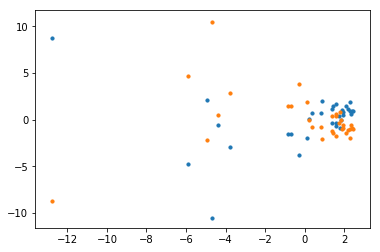

In [5]:
dim=26

Xframe =  getDataFrame('all',trace=True)
#print(Xframe.head())
#print(Xframe.describe())

Xf=np.array(Xframe)
Xd=reduceDim(Xf,dim=dim,trace=True,check=True)
x=0
y=x+1
plt.scatter(Xd[:, x], Xd[:, y], s=10);


test =  getDataFrame(dim)
Xl=np.array(test)
X26r=np.array(Xl[:,1:],dtype=float)
print(X26r.shape)

plt.scatter(X26r[:, x], X26r[:, y], s=10);
print(np.linalg.norm(X26r-Xd))


In [ ]:
n_cluster=4
n_init=10000
max_iter=20

kmeans =KMeans(n_clusters=n_cluster,n_init=n_init, max_iter=max_iter)
kmeans.fit(Xd)

In [ ]:
print('cost    :'+str(kmeans.inertia_))
print('iter :'+str(kmeans.n_iter_))
plt.scatter(Xd[:, 0], Xd[:, 1], c=kmeans.labels_, s=15, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=40, alpha=0.5)
printCluster(Xframe,kmeans.labels_)

In [ ]:
n_cluster=4
n_init=1000
max_iter=200

clf = mixture.GaussianMixture(n_components=n_cluster, n_init = n_init, 
                              covariance_type='full', verbose=0, tol=1e-4)
clf.fit(Xd)
labels = clf.predict(Xd)
#probs=clf.predict_proba(Xd)

In [ ]:
print('lower bound    :'+str(clf.lower_bound_))
#print('converged :'+str(clf.converged_))
print('iter :'+str(clf.n_iter_))
printCluster(Xf,labels)
#print(clf.weights_)
plt.scatter(Xd[:, 0], Xd[:, 1], c=labels, s=15, cmap='viridis')

In [ ]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
#    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=15, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_[:2], gmm.covariances_[:,:2,:2], gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

In [ ]:
plot_gmm(clf, Xd)